# Use DQN to Play MoutainCar-v0

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools
import copy

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(0)

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('MountainCar-v0')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

22:49:45 [INFO] env: <MountainCarEnv<MountainCar-v0>>
22:49:45 [INFO] action_space: Discrete(3)
22:49:45 [INFO] observation_space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
22:49:45 [INFO] reward_range: (-inf, inf)
22:49:45 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 30}
22:49:45 [INFO] _max_episode_steps: 200
22:49:45 [INFO] _elapsed_steps: None


In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class DQNAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.replayer = DQNReplayer(10000)

        self.evaluate_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[64, 64], output_size=self.action_n)
        self.optimizer = optim.Adam(self.evaluate_net.parameters(), lr=0.001)
        self.loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        model = nn.Sequential(*layers)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.target_net = copy.deepcopy(self.evaluate_net)

    def step(self, observation, reward, done):
        if self.mode == 'train' and np.random.rand() < 0.001:
            # epsilon-greedy policy in train mode
            action = np.random.randint(self.action_n)
        else:
            state_tensor = torch.as_tensor(observation,
                    dtype=torch.float).squeeze(0)
            q_tensor = self.evaluate_net(state_tensor)
            action_tensor = torch.argmax(q_tensor)
            action = action_tensor.item()
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                state, _, _, act, next_state, reward, done, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, act, reward, next_state, done)
            if self.replayer.count >= self.replayer.capacity * 0.95:
                    # skip first few episodes for speed
                self.learn()
        return action

    def close(self):
        pass

    def learn(self):
        # replay
        states, actions, rewards, next_states, dones = \
                self.replayer.sample(1024) # replay transitions
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        action_tensor = torch.as_tensor(actions, dtype=torch.long)
        reward_tensor = torch.as_tensor(rewards, dtype=torch.float)
        next_state_tensor = torch.as_tensor(next_states, dtype=torch.float)
        done_tensor = torch.as_tensor(dones, dtype=torch.float)

        # train
        next_q_tensor = self.target_net(next_state_tensor)
        next_max_q_tensor, _ = next_q_tensor.max(axis=-1)
        target_tensor = reward_tensor + self.gamma * (1. - done_tensor) * next_max_q_tensor
        pred_tensor = self.evaluate_net(state_tensor)
        q_tensor = pred_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
        loss_tensor = self.loss(target_tensor, q_tensor)
        self.optimizer.zero_grad()
        loss_tensor.backward()
        self.optimizer.step()


agent = DQNAgent(env)

22:49:46 [INFO] ==== train ====
22:49:46 [DEBUG] train episode 0: reward = -200.00, steps = 200


22:49:46 [DEBUG] train episode 1: reward = -200.00, steps = 200
22:49:46 [DEBUG] train episode 2: reward = -200.00, steps = 200
22:49:46 [DEBUG] train episode 3: reward = -200.00, steps = 200
22:49:47 [DEBUG] train episode 4: reward = -200.00, steps = 200
22:49:47 [DEBUG] train episode 5: reward = -200.00, steps = 200
22:49:47 [DEBUG] train episode 6: reward = -200.00, steps = 200
22:49:47 [DEBUG] train episode 7: reward = -200.00, steps = 200
22:49:47 [DEBUG] train episode 8: reward = -200.00, steps = 200
22:49:48 [DEBUG] train episode 9: reward = -200.00, steps = 200
22:49:48 [DEBUG] train episode 10: reward = -200.00, steps = 200
22:49:48 [DEBUG] train episode 11: reward = -200.00, steps = 200
22:49:48 [DEBUG] train episode 12: reward = -200.00, steps = 200
22:49:48 [DEBUG] train episode 13: reward = -200.00, steps = 200
22:49:49 [DEBUG] train episode 14: reward = -200.00, steps = 200
22:49:49 [DEBUG] train episode 15: reward = -200.00, steps = 200
22:49:49 [DEBUG] train episode 16:

00:38:43 [DEBUG] train episode 127: reward = -200.00, steps = 200
00:40:10 [DEBUG] train episode 128: reward = -200.00, steps = 200
00:41:42 [DEBUG] train episode 129: reward = -200.00, steps = 200
00:43:15 [DEBUG] train episode 130: reward = -200.00, steps = 200
00:44:46 [DEBUG] train episode 131: reward = -200.00, steps = 200
00:46:17 [DEBUG] train episode 132: reward = -200.00, steps = 200
00:47:48 [DEBUG] train episode 133: reward = -200.00, steps = 200
00:49:19 [DEBUG] train episode 134: reward = -200.00, steps = 200
00:50:50 [DEBUG] train episode 135: reward = -200.00, steps = 200
00:52:22 [DEBUG] train episode 136: reward = -200.00, steps = 200
00:53:53 [DEBUG] train episode 137: reward = -200.00, steps = 200
00:55:24 [DEBUG] train episode 138: reward = -200.00, steps = 200
00:56:55 [DEBUG] train episode 139: reward = -200.00, steps = 200
00:58:13 [DEBUG] train episode 140: reward = -200.00, steps = 200
00:59:36 [DEBUG] train episode 141: reward = -200.00, steps = 200
01:01:07 [

03:35:06 [DEBUG] train episode 252: reward = -200.00, steps = 200
03:36:13 [DEBUG] train episode 253: reward = -200.00, steps = 200
03:36:56 [DEBUG] train episode 254: reward = -123.00, steps = 123
03:38:02 [DEBUG] train episode 255: reward = -191.00, steps = 191
03:39:10 [DEBUG] train episode 256: reward = -200.00, steps = 200
03:39:58 [DEBUG] train episode 257: reward = -140.00, steps = 140
03:40:41 [DEBUG] train episode 258: reward = -124.00, steps = 124
03:41:22 [DEBUG] train episode 259: reward = -121.00, steps = 121
03:42:14 [DEBUG] train episode 260: reward = -150.00, steps = 150
03:43:03 [DEBUG] train episode 261: reward = -144.00, steps = 144
03:43:38 [DEBUG] train episode 262: reward = -101.00, steps = 101
03:44:28 [DEBUG] train episode 263: reward = -145.00, steps = 145
03:45:21 [DEBUG] train episode 264: reward = -158.00, steps = 158
03:45:55 [DEBUG] train episode 265: reward = -98.00, steps = 98
03:46:29 [DEBUG] train episode 266: reward = -98.00, steps = 98
03:47:00 [DEBU

04:36:31 [DEBUG] test episode 36: reward = -115.00, steps = 115
04:36:31 [DEBUG] test episode 37: reward = -113.00, steps = 113
04:36:31 [DEBUG] test episode 38: reward = -112.00, steps = 112
04:36:31 [DEBUG] test episode 39: reward = -111.00, steps = 111
04:36:31 [DEBUG] test episode 40: reward = -84.00, steps = 84
04:36:31 [DEBUG] test episode 41: reward = -84.00, steps = 84
04:36:31 [DEBUG] test episode 42: reward = -200.00, steps = 200
04:36:31 [DEBUG] test episode 43: reward = -83.00, steps = 83
04:36:31 [DEBUG] test episode 44: reward = -110.00, steps = 110
04:36:31 [DEBUG] test episode 45: reward = -85.00, steps = 85
04:36:32 [DEBUG] test episode 46: reward = -116.00, steps = 116
04:36:32 [DEBUG] test episode 47: reward = -145.00, steps = 145
04:36:32 [DEBUG] test episode 48: reward = -90.00, steps = 90
04:36:32 [DEBUG] test episode 49: reward = -115.00, steps = 115
04:36:32 [DEBUG] test episode 50: reward = -91.00, steps = 91
04:36:32 [DEBUG] test episode 51: reward = -111.00, 

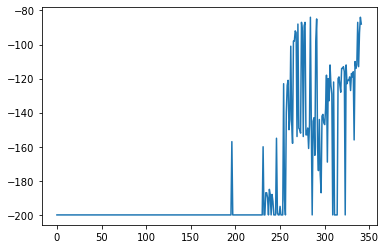

In [5]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -110:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [6]:
env.close()